<a href="https://colab.research.google.com/github/arman258/CNG-562/blob/master/MALEKLOO_otto_group_product_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### Ensemble learning (espically stacking) can be used to improve the accuarcy. However this was not used in this HW







In [0]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [0]:
!pip install lightgbm
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

Note: You should import your Kaggle .json API credentials. 


In [0]:
# import os
# import shutil
# if not os.path.exists('.kaggle'):
#     os.mkdir('.kaggle')
#     shutil.move('Downloads/kaggle.json','.kaggle')
# os.chmod('.kaggle/kaggle.json',600)
from google.colab import files
files.upload()

In [0]:
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
! kaggle competitions download otto-group-product-classification-challenge -p OTTO

  0% 0.00/3.34M [00:00<?, ?B/s]
100% 3.34M/3.34M [00:00<00:00, 109MB/s]
  0% 0.00/1.59M [00:00<?, ?B/s]
100% 1.59M/1.59M [00:00<00:00, 107MB/s]
  0% 0.00/3.79M [00:00<?, ?B/s]
100% 3.79M/3.79M [00:00<00:00, 126MB/s]


In [0]:
!unzip -qq OTTO/test.csv -d OTTO 
!unzip -qq OTTO/train.csv -d OTTO 
!rm -rf OTTO/test.csv.zip
!rm -rf OTTO/train.csv.zip

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import LabelBinarizer,MultiLabelBinarizer, label_binarize

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [0]:
train = pd.read_csv('OTTO/train.csv',index_col=0)
test = pd.read_csv('OTTO/test.csv',index_col=0)

In [55]:
train.head()
test.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,1,0,4,1,1,0,0,2,0,0,0,0,0,1,0,0,0,0,1,...,0,0,2,0,0,11,0,1,1,0,1,0,7,0,0,0,1,0,0,0,0,0,0,0,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,Class_1
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,2,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Class_1
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,6,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,Class_1
4,1,0,0,1,6,1,5,0,0,1,1,0,1,0,0,1,1,0,0,0,0,0,0,7,2,2,0,0,0,58,0,10,0,0,0,0,0,3,0,0,...,1,0,0,0,0,0,0,0,0,0,2,1,5,0,0,4,0,0,2,1,0,1,0,0,1,1,2,2,0,22,0,1,2,0,0,0,0,0,0,Class_1
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,4,0,1,0,0,0,1,0,0,0,0,1,0,0,0,Class_1


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,...,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,3,0,0,0,3,2,1,0,0,0,0,0,0,0,5,3,1,1,0,0,0,0,0,1,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,11,1,20,0,0,0,0,0
2,2,2,14,16,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,2,0,4,0,4,0,0,0,0,2,0,0,0,8,0,0,0,0,0,...,24,0,0,0,0,0,0,0,0,0,6,8,0,0,0,0,0,0,0,0,0,0,0,2,0,0,4,0,2,0,0,0,0,0,0,4,0,0,2,0
3,0,1,12,1,0,0,0,0,0,0,7,1,0,0,0,7,0,2,0,0,0,4,0,0,0,1,1,2,0,0,0,0,0,0,1,0,0,2,0,0,...,10,1,0,2,0,0,1,6,1,1,0,0,1,1,1,2,0,0,2,0,0,0,0,0,0,0,6,0,2,0,0,0,0,0,2,0,0,0,0,1
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,21,3,0,0,0,0,0,0,0,0,4,0,0,0,1,0,0,0,2,0,0,0,0,1,0,0,...,2,0,0,0,0,0,0,0,9,0,0,2,0,0,0,0,6,0,8,0,0,0,0,1,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0
5,1,0,0,1,0,0,1,2,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,4,0,5,16,0,0,0,0,0,0,1,0,0,0,0,0,0,0,9,0,0


In [0]:
def missing_values(data):
    for i,j in list(zip(data.columns, (data.isnull().sum()))):
        if j>1:
            print (f"{i}: missing {j}")
        
missing_values(train)     

,target
Class_2,16122
Class_6,14135
Class_8,8464
Class_3,8004
Class_9,4955
Class_7,2839
Class_5,2739
Class_4,2691
Class_1,1929


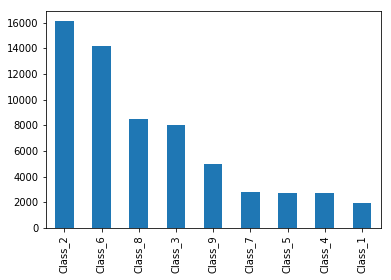

In [0]:
train["target"].value_counts().plot.bar()
pd.DataFrame(train["target"].value_counts())


In [0]:
# train['target'] = train['target'].str[-1].astype(int) - 1

In [56]:
scaler = StandardScaler()
lbe = LabelEncoder ()
train['target'] = lbe.fit_transform(train['target'])

train.target.unique()

# lb = LabelBinarizer()
# train['target'] = label_binarize(train['target'], classes=[0, 1, 2, 3, 4, 5, 6 ,7 ,8])




array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [0]:
for col in train.columns[:-1]:
    train[col] = scaler.fit_transform(train[col].values.reshape(-1,1))
    test[col] = scaler.transform(test[col].values.reshape(-1,1))

In [58]:
train.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.402093,-0.210106,-0.307165,-0.279443,-0.161867,-0.119331,-0.188045,-0.293664,-0.291038,-0.243606,-0.083117,-0.248418,-0.238737,-0.536388,-0.332556,-0.634936,1.105906,-0.430714,-0.119,-0.32774,-0.293105,0.186717,-0.182027,0.292963,-0.229115,0.255449,-0.242452,-0.288575,0.906880,-0.091605,-0.165688,-0.431886,-0.531614,-0.280951,0.104360,-0.277519,-0.348292,-0.363248,-0.147223,-0.197910,...,-0.323529,-0.157741,1.562546,-0.175207,-0.150758,3.292142,-0.235612,-0.070335,0.878729,-0.369423,0.993266,-0.419797,0.824711,-0.223108,-0.197304,-0.45988,0.585591,-0.356076,-0.102201,-0.154306,-0.227125,-0.256320,-0.136989,-0.131885,1.322035,0.134452,-0.170108,-0.224789,-0.204,-0.061446,0.246100,-0.420870,-0.249802,-0.413584,-0.299712,-0.176699,-0.129516,-0.386938,-0.104963,0
2,-0.253508,-0.210106,-0.307165,-0.279443,-0.161867,-0.119331,-0.188045,0.149647,-0.291038,-0.243606,-0.411815,-0.248418,-0.238737,-0.536388,-0.332556,-0.634936,-0.247801,1.066321,-0.119,-0.32774,-0.293105,-0.504746,-0.182027,-0.571159,-0.657752,-0.329247,-0.242452,-0.288575,-0.145044,-0.091605,-0.165688,-0.431886,-0.531614,-0.280951,-0.208341,-0.277519,0.972838,-0.363248,-0.147223,-0.500962,...,-0.323529,-0.157741,-0.285646,0.075817,-0.150758,-0.340085,-0.235612,-0.445327,-0.178185,-0.075483,-0.283799,-0.419797,-0.381493,-0.223108,-0.197304,-0.45988,-0.274673,-0.356076,0.243629,0.111808,-0.227125,0.086145,-0.136989,0.228048,-0.233708,-0.310853,-0.170108,-0.224789,-0.204,-0.061446,-0.280099,-0.420870,-0.249802,-0.413584,-0.299712,-0.176699,-0.129516,-0.386938,-0.104963,0
3,-0.253508,-0.210106,-0.307165,-0.279443,-0.161867,-0.119331,-0.188045,0.149647,-0.291038,-0.243606,-0.411815,-0.248418,-0.238737,-0.536388,-0.332556,-0.634936,0.429052,-0.430714,-0.119,-0.32774,-0.293105,-0.504746,-0.182027,-0.571159,-0.657752,-0.329247,-0.242452,-0.288575,-0.145044,-0.091605,-0.165688,-0.431886,0.231634,-0.280951,-0.208341,-0.277519,-0.348292,-0.363248,-0.147223,-0.500962,...,0.677738,-0.157741,-0.285646,-0.175207,-0.150758,-0.340085,-0.235612,-0.445327,-0.178185,-0.369423,-0.283799,-0.419797,0.623677,-0.223108,-0.197304,0.57033,-0.274673,-0.356076,-0.102201,-0.154306,-0.227125,-0.256320,-0.136989,-0.131885,-0.233708,-0.310853,1.997960,-0.224789,-0.204,-0.061446,-0.280099,-0.420870,-0.249802,-0.413584,-0.299712,-0.176699,-0.129516,-0.386938,-0.104963,0
4,0.402093,-0.210106,-0.307165,0.079240,13.508710,4.524667,4.665884,-0.293664,-0.291038,0.679472,-0.083117,-0.248418,0.257620,-0.536388,-0.332556,-0.185729,0.429052,-0.430714,-0.119,-0.32774,-0.293105,-0.504746,-0.182027,0.941055,0.199522,0.840145,-0.242452,-0.288575,-0.145044,35.255576,-0.165688,3.705766,-0.531614,-0.280951,-0.208341,-0.277519,-0.348292,1.508750,-0.147223,-0.500962,...,0.677738,-0.157741,-0.285646,-0.175207,-0.150758,-0.340085,-0.235612,-0.445327,-0.178185,-0.369423,2.270330,0.314492,0.422643,-0.223108,-0.197304,1.60054,-0.274673,-0.356076,0.243629,0.111808,-0.227125,0.086145,-0.136989,-0.131885,0.544163,0.134452,4.166029,2.166806,-0.204,19.044887,-0.280099,-0.047949,1.019683,-0.413584,-0.299712,-0.176699,-0.129516,-0.386938,-0.104963,0
5,-0.253508,-0.210106,-0.307165,-0.279443,-0.161867,-0.119331,-0.188045,-0.293664,-0.291038,-0.243606,-0.411815,-0.248418,-0.238737,-0.536388,-0.332556,-0.634936,2.459613,-0.430

In [59]:
feature = train.drop('target',axis=1)
target = train['target']
feature.head()
target.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,...,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.402093,-0.210106,-0.307165,-0.279443,-0.161867,-0.119331,-0.188045,-0.293664,-0.291038,-0.243606,-0.083117,-0.248418,-0.238737,-0.536388,-0.332556,-0.634936,1.105906,-0.430714,-0.119,-0.32774,-0.293105,0.186717,-0.182027,0.292963,-0.229115,0.255449,-0.242452,-0.288575,0.906880,-0.091605,-0.165688,-0.431886,-0.531614,-0.280951,0.104360,-0.277519,-0.348292,-0.363248,-0.147223,-0.197910,...,-0.260732,-0.323529,-0.157741,1.562546,-0.175207,-0.150758,3.292142,-0.235612,-0.070335,0.878729,-0.369423,0.993266,-0.419797,0.824711,-0.223108,-0.197304,-0.45988,0.585591,-0.356076,-0.102201,-0.154306,-0.227125,-0.256320,-0.136989,-0.131885,1.322035,0.134452,-0.170108,-0.224789,-0.204,-0.061446,0.246100,-0.420870,-0.249802,-0.413584,-0.299712,-0.176699,-0.129516,-0.386938,-0.104963
2,-0.253508,-0.210106,-0.307165,-0.279443,-0.161867,-0.119331,-0.188045,0.149647,-0.291038,-0.243606,-0.411815,-0.248418,-0.238737,-0.536388,-0.332556,-0.634936,-0.247801,1.066321,-0.119,-0.32774,-0.293105,-0.504746,-0.182027,-0.571159,-0.657752,-0.329247,-0.242452,-0.288575,-0.145044,-0.091605,-0.165688,-0.431886,-0.531614,-0.280951,-0.208341,-0.277519,0.972838,-0.363248,-0.147223,-0.500962,...,-0.503847,-0.323529,-0.157741,-0.285646,0.075817,-0.150758,-0.340085,-0.235612,-0.445327,-0.178185,-0.075483,-0.283799,-0.419797,-0.381493,-0.223108,-0.197304,-0.45988,-0.274673,-0.356076,0.243629,0.111808,-0.227125,0.086145,-0.136989,0.228048,-0.233708,-0.310853,-0.170108,-0.224789,-0.204,-0.061446,-0.280099,-0.420870,-0.249802,-0.413584,-0.299712,-0.176699,-0.129516,-0.386938,-0.104963
3,-0.253508,-0.210106,-0.307165,-0.279443,-0.161867,-0.119331,-0.188045,0.149647,-0.291038,-0.243606,-0.411815,-0.248418,-0.238737,-0.536388,-0.332556,-0.634936,0.429052,-0.430714,-0.119,-0.32774,-0.293105,-0.504746,-0.182027,-0.571159,-0.657752,-0.329247,-0.242452,-0.288575,-0.145044,-0.091605,-0.165688,-0.431886,0.231634,-0.280951,-0.208341,-0.277519,-0.348292,-0.363248,-0.147223,-0.500962,...,-0.503847,0.677738,-0.157741,-0.285646,-0.175207,-0.150758,-0.340085,-0.235612,-0.445327,-0.178185,-0.369423,-0.283799,-0.419797,0.623677,-0.223108,-0.197304,0.57033,-0.274673,-0.356076,-0.102201,-0.154306,-0.227125,-0.256320,-0.136989,-0.131885,-0.233708,-0.310853,1.997960,-0.224789,-0.204,-0.061446,-0.280099,-0.420870,-0.249802,-0.413584,-0.299712,-0.176699,-0.129516,-0.386938,-0.104963
4,0.402093,-0.210106,-0.307165,0.079240,13.508710,4.524667,4.665884,-0.293664,-0.291038,0.679472,-0.083117,-0.248418,0.257620,-0.536388,-0.332556,-0.185729,0.429052,-0.430714,-0.119,-0.32774,-0.293105,-0.504746,-0.182027,0.941055,0.199522,0.840145,-0.242452,-0.288575,-0.145044,35.255576,-0.165688,3.705766,-0.531614,-0.280951,-0.208341,-0.277519,-0.348292,1.508750,-0.147223,-0.500962,...,0.225497,0.677738,-0.157741,-0.285646,-0.175207,-0.150758,-0.340085,-0.235612,-0.445327,-0.178185,-0.369423,2.270330,0.314492,0.422643,-0.223108,-0.197304,1.60054,-0.274673,-0.356076,0.243629,0.111808,-0.227125,0.086145,-0.136989,-0.131885,0.544163,0.134452,4.166029,2.166806,-0.204,19.044887,-0.280099,-0.047949,1.019683,-0.413584,-0.299712,-0.176699,-0.129516,-0.386938,-0.104963
5,-0.253508,-0.210106,-0.307165,-0.279443,-0.161867,-0.119331,-0.188045,-0.293664,-0.291038,-0.243606,-0.411815,-0.248418,-0.238737,-0.536388,-0.

id
1    0
2    0
3    0
4    0
5    0
Name: target, dtype: int64

In [0]:
# pca = PCA(.95)
# feature = pca.fit_transform(feature)
# test = pca.transform(test)

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier
import lightgbm as lgb
from sklearn.preprocessing import LabelBinarizer,MultiLabelBinarizer
from sklearn.metrics import roc_curve, log_loss, roc_auc_score

from sklearn.model_selection import cross_val_score,GridSearchCV, cross_validate, KFold
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier



In [0]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size = 0.25)

In [0]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

parameters = {
    'application': 'multiclass',
    'objective': 'binary',
    'metric': ('auc'),
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.02,
    'verbose': 0,
    'max_bin': 500
}

evals_result={}
gbm = lgb.train(parameters,
                lgb_train,
                num_boost_round=50,
                valid_sets=[lgb_train, lgb_eval],
                early_stopping_rounds=50,
                evals_result=evals_result)

[1]	training's auc: 0.88186	valid_1's auc: 0.845959
Training until validation scores don't improve for 50 rounds.
[2]	training's auc: 0.908163	valid_1's auc: 0.885395
[3]	training's auc: 0.918242	valid_1's auc: 0.89265
[4]	training's auc: 0.927254	valid_1's auc: 0.900426
[5]	training's auc: 0.933433	valid_1's auc: 0.906891
[6]	training's auc: 0.937348	valid_1's auc: 0.910492
[7]	training's auc: 0.940665	valid_1's auc: 0.913767
[8]	training's auc: 0.942269	valid_1's auc: 0.915467
[9]	training's auc: 0.943435	valid_1's auc: 0.916676
[10]	training's auc: 0.944821	valid_1's auc: 0.918178
[11]	training's auc: 0.946208	valid_1's auc: 0.919211
[12]	training's auc: 0.94724	valid_1's auc: 0.920572
[13]	training's auc: 0.948036	valid_1's auc: 0.921598
[14]	training's auc: 0.948586	valid_1's auc: 0.922063
[15]	training's auc: 0.949534	valid_1's auc: 0.923022
[16]	training's auc: 0.950146	valid_1's auc: 0.923358
[17]	training's auc: 0.950876	valid_1's auc: 0.92385
[18]	training's auc: 0.951266	val

<function lightgbm.plotting.plot_tree>

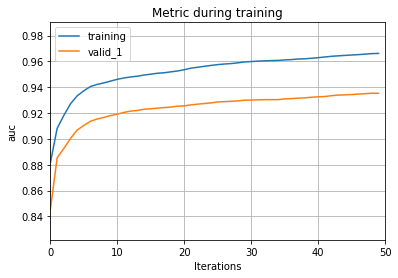

In [0]:
ax = lgb.plot_metric(evals_result, metric='auc')
plt.show()

In [0]:
lgb.cv(parameters, lgb_train, 20, nfold=10)

{'auc-mean': [0.8571886902512338,
  0.8928922991680119,
  0.9031411438316848,
  0.9130088714763053,
  0.9186818275977714,
  0.9228003138130905,
  0.9253101374803199,
  0.927104385494874,
  0.9284789090925752,
  0.9300731816364278,
  0.9310836096795638,
  0.9317968833064871,
  0.9325647553950415,
  0.9331180200204793,
  0.9338673643557762,
  0.9342967726213164,
  0.9347346107740113,
  0.935192378934001,
  0.93566367951732,
  0.9361632382468474],
 'auc-stdv': [0.011855737698079355,
  0.009775371345714634,
  0.008290077776700384,
  0.006974857803820316,
  0.006526383793894637,
  0.005562456053882112,
  0.005746503278273487,
  0.005663758457105966,
  0.005592709920258464,
  0.005313266608309898,
  0.005182982813521982,
  0.005251739118632006,
  0.005384453986501933,
  0.005425504476284574,
  0.0053124554479898585,
  0.005158840990795841,
  0.005067761488964946,
  0.004887319582755141,
  0.004957002619191339,
  0.0049301740365103675]}

In [0]:
clf_log = LogisticRegression(n_jobs=-1)
clf_forest = RandomForestClassifier(n_jobs=-1)
clf_tree = DecisionTreeClassifier()
clf_knn = KNeighborsClassifier(n_jobs=-1)
clf_svc = SVC()


models = {
#          'log Rgression':clf_log,
         'Random Forest Classifier':clf_forest,
         'Decision Tree Classifer':clf_tree,
         'KNeighbors Classifer':clf_knn,
#          'Support Vector Classification':clf_svc
         }


In [0]:
# OneVsRestClassifier?

In [62]:
feature = train.drop('target',axis=1)
target = train['target']
feature.shape
target.shape

(61878, 93)

(61878,)

In [63]:
pca = PCA(.95)
feature = pca.fit_transform(feature)
feature.shape

(61878, 77)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size = 0.25)

In [0]:
acc_score = {}
for name,model in models.items():
    model.fit(X_train,y_train)
    predict = model.predict(X_test)
    acc_score[name] = accuracy_score(y_test,predict)

pd.DataFrame.from_dict(acc_score, orient='index', columns=["Accuracy Score" ])   

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

,Accuracy Score
Random Forest Classifier,0.754234
Decision Tree Classifer,0.677376
KNeighbors Classifer,0.774919


In [71]:
lb = LabelBinarizer()

target_roc= lb.fit_transform(target)

target_roc.shape

(61878, 9)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(feature, target_roc, test_size = 0.25)

ROC for Random Forest

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          n_jobs=None)

0.9225527771993937


<Figure size 864x720 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic example')

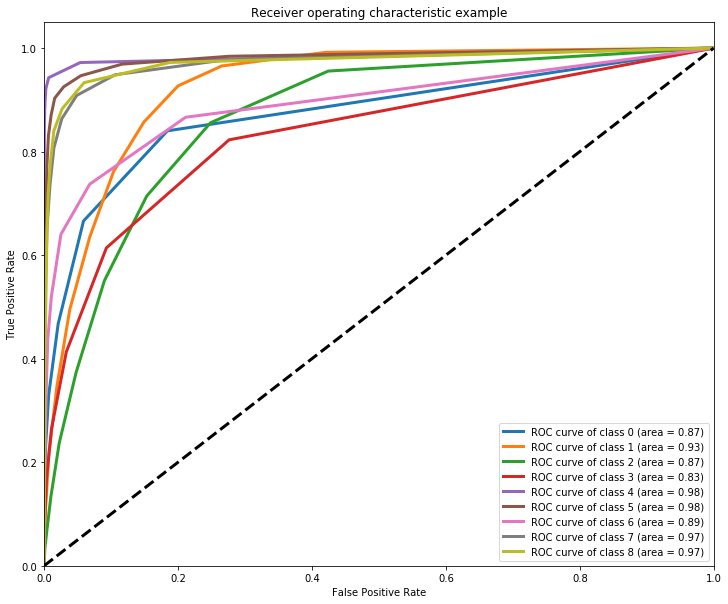

In [73]:
model = clf_forest
model = OneVsRestClassifier(model)
model.fit(X_train,y_train)
predict_prob=model.predict_proba(X_test)    

print (roc_auc_score(y_test, predict_prob))

fpr = dict()
tpr = dict()
roc_auc = dict()
plt.figure(figsize=(12,10))
for i in range(target.shape[1]):
    lw=3
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], predict_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=lw,label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [0]:
from sklearn.base import BaseEstimator
class DummyEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass

cv_pipe = Pipeline([('estimator', DummyEstimator())])

classifier = dict()

# classifier["Random Forest Classifier"] = {
#     'estimator':[clf_forest],
# #     'estimator__criterion':['mse','mae'],
#     'estimator__n_estimators':np.arange(200,700,100),
# #     'estimator__max_depth':np.linspace(10, 110, num = 11)
#     }

# classifier["Decision Tree Classifier"] = {

#     'estimator': [clf_tree],
# #     'estimator__max_depth':np.linspace(10, 110, num = 11),
#     'estimator__criterion' : ['gini','entropy'],
#     'estimator__min_samples_split':np.linspace(0.01,1,num=10)
#     }

classifier["KNeighbors Classifier"]={
    'estimator':[clf_knn],
    'estimator__n_neighbors':np.arange(2,50,5),
    'estimator__weights':["uniform","distance"]
    }

# classifier["Support Vector Classifier"]={
#     'estimator':[clf_svc],
#     'estimator__kernel': ['linear', 'rbf'],
#     'estimator__C': [0.001,0.01,0.1,1,10,100,1000],
#     'estimator__gamma': [0.001,0.01,0.1,1,10,100,1000],
#     }

In [0]:
grid_score = {}
for key in regressors:
    grid = GridSearchCV(cv_pipe,param_grid=regressors[key], cv=3, scoring='accuracy')
    grid.fit(X_train,y_train)
    grid_score[key]=abs(grid.best_score_)
#     print(f"{key}: Mean Squared Error is : {abs(grid.best_score_)}\n")
    print(grid.best_params_)
pd.DataFrame.from_dict(grid_score, orient='index', columns=["accuracy score"])  

In [0]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(solver='adam',activation='relu',max_iter=250, hidden_layer_sizes= (30, 10), alpha= 1e-5)
mlp.fit(X_train, y_train)
predict = mlp.predict(X_test)
trian_score =  mlp.score(X_train, y_train)
test_score =  mlp.score(X_test, y_test)
# mlp_cv = cross_val_score(mlp, X_train, y_train)


print (f"Accuracy Score is : {accuracy_score(y_test, predict)}")



MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(30, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=250, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

Accuracy Score is : 0.7792501616031028
